tl;dr _I visualized the local time of sunset today (2018-01-27) at every county in the continental US to see how sunset time depends on latitude and location within timezone._

---

I'm currently traveling through the pacific northwest (PNW) and have been surprised that sunset occurs at about the same (local) time as it does out in Princeton, NJ (where I currently live), despite the ~5 degree difference in latitude. It occurred to me that the local time of sunset probably depends a lot on your relative position within a timezone (at least within the continental US), so I wanted to make some visualizations related to this.

The machinery to do this in Python exists, but is spread out over a number of packages (listed below in the imports block). The code below takes a few minutes to run, and the bottleneck is the calculation used to estimate the time of sunset at each county's mean position (latitude and longitude).

Some notes about installing the necessary packages:
* I installed basemap with conda using: `conda install -c conda-forge basemap`
* I installed the `geos` C library with homebrew with: `brew install geos`
* I `pip` installed `tzwhere`, but everything else was installed with conda.

In [1]:
# Standard library
import datetime

# Third-party
import astropy.units as u
import astropy.coordinates as coord
from astropy.time import Time
import numpy as np
import pandas as pd
import pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import argrelmin

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

In [2]:
from tzwhere import tzwhere
tz = tzwhere.tzwhere(forceTZ=True)

On top of the software installs above, I had to download a bunch of data from the US census bureau that contains the county shape specifications and other metadata https://www.census.gov/geo/maps-data/data/gazetteer2017.html: from this link, click "Counties", and download the full text file (only a few hundred kB). I saved this file locally as "US-counties.txt". I found that I had to manually go in and delete a weird character on the first line, but afterwards was able to read it with pandas:

In [3]:
county = pd.read_csv('../static/US-counties.txt', delimiter='\t')
len(county)

3220

For every county location (latitude and longitude), I use the `tzwhere` package to convert the (lat, lon) combo to a timezone name. For example, for New York:

In [4]:
tz.tzNameAt(40.713, -74.006)

'America/New_York'

We now do the same, but iterate over the US counties file:

In [5]:
tzs = np.array([pytz.timezone(tz.tzNameAt(r['INTPTLAT'], r['INTPTLONG'], forceTZ=True))
                for i, r in county.iterrows()])

Let's look at a random entry in this array:

In [6]:
tzs[867]

<DstTzInfo 'America/Chicago' LMT-1 day, 18:09:00 STD>

From the (lat, lon) coordinates of each county center, I now create an array-valued [`EarthLocation`](http://docs.astropy.org/en/latest/api/astropy.coordinates.EarthLocation.html) object, which I'll later use to get the Sun's local altitude at each position and a grid of times:

In [7]:
county_locs = coord.EarthLocation(lon=county['INTPTLONG']*u.deg, 
                                  lat=county['INTPTLAT']*u.deg)

Now we'll define a function that will do the majority of the computation: compute the local time of sunset at the specified locations and on the specified day:

In [8]:
day = Time('2018-01-27')

In [24]:
def sunset_time(locs, time, n_time=256):
    """Estimate the local time of sunset at the specified locations 
    on the specified date. 
    
    Parameters
    ----------
    locs : `astropy.coordinates.EarthLocation`
        The positions to compute sunset at.
    time : `astropy.time.Time`
        The UTC day to compute sunset on.
    n_time : int (optional)
        The number of time grid points to use to estimate sunset.
    """
    # UTC timezone used below to convert to local time
    utc = pytz.timezone('UTC')
    
    # Generate a grid of times to use to search for sunset:
    time_grid = time + np.linspace(0, 24, n_time) * u.hour
    
    # Get the Sun's position at all of the (UTC) times:
    sun = coord.get_sun(time_grid[:, None])
    
    # Create a 2D grid of AltAz frames given the locations 
    # and times, then compute the Sun's local altitude and azimuth
    # at each of those frames:
    altaz_frame = coord.AltAz(location=locs[None], 
                              obstime=time_grid[:,None])
    sun_altaz = sun.transform_to(altaz_frame)
    
    # Find the indices of all minima in the sun altitude^2 -- there 
    # should be 2: close to sunset, and close to sunrise:
    min_idx = np.array([argrelmin(a**2, axis=0, mode='wrap')[0] 
                        for a in sun_altaz.alt.degree.T])
    
    # Now, figure out which of the two sun altitude minima is sunset
    # by computing the derivative of altitude w.r.t. time:
    sunset_idx = []
    good_i = []
    for i, idx in enumerate(min_idx):
        alt = sun_altaz.alt.degree
        try:
            sunset_idx.append(idx[np.array([alt[min(j+1, len(alt)-1), i] - alt[max(j-1, 0), i] 
                                            for j in idx]) < 0][0])
            good_i.append(i)
        except IndexError:
            continue
    
    sunset_idx = np.array(sunset_idx)
    good_i = np.array(good_i)
    
    # Convert the UTC sunset time estimates to local times. Here we 
    # assume that the time sampling is dense enough that the time of 
    # min(alt**2) is close enough to the actual sunset:
    sun_time = sun_altaz.obstime.datetime
    sunsets = np.array([utc.localize(sun_time[j,i]).astimezone(tzs[i])
                        for i, j in zip(good_i, sunset_idx)])
    
    return good_i, sunsets

In [25]:
%%time
good_i, sunsets = sunset_time(county_locs, day, n_time=512)

CPU times: user 3min 52s, sys: 3.91 s, total: 3min 56s
Wall time: 4min 6s


The times we get back are an array of python datetime objects, but we only care about local (decimal) time. Here we convert the datetime objects to decimal hours:

In [26]:
sunset_hours = np.array([s.hour + s.minute/60 + s.second/3600 
                         for s in sunsets])

Before using `basemap` to plot the counties as polygons, let's just make sure we're on the right track by plotting the county centroids, colored by sunset time:

(25, 55)

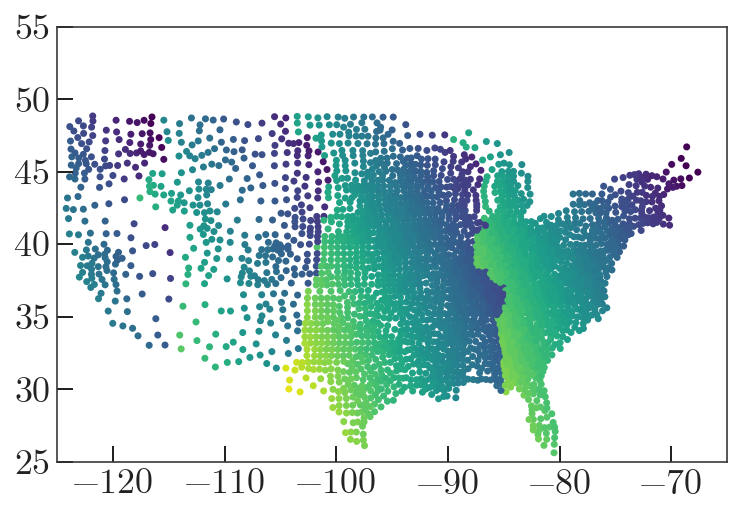

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(county_locs[good_i].lon.degree, 
           county_locs[good_i].lat.degree, 
           marker='.', c=sunset_hours, 
           vmin=16.5, vmax=18.5)
ax.set_xlim(-125, -65)
ax.set_ylim(25, 55)

Now we can make a plot of the counties, drawn as polygons, colored by the time of sunset. We need to specify the edges of the plot (in latitude and longitude) and the central point so `basemap` can compute the projection for us:

In [28]:
# Set the lower left and upper right limits of the bounding box of 
# the US county map plot:
lon_lim = (-119, -63)
lat_lim = (22.0, 50.5)

# calculate the centerpoint, needed for the projection:
center_lon = 0.5 * np.sum(lon_lim)
center_lat = 0.5 * np.sum(lat_lim)

For our county map, we'll use a diverging colormap to show differences in the time of sunset from the median time of sunset (rounded to the nearest half hour):

In [29]:
cmap = plt.get_cmap('RdBu')

med_hour = 0.5 * np.round(np.median(sunset_hours) / 0.5)
print('median sunset (local) time: {0}'.format(med_hour))

norm = mpl.colors.Normalize(vmin=med_hour - 1, 
                            vmax=med_hour + 1)

median sunset (local) time: 17.5


/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


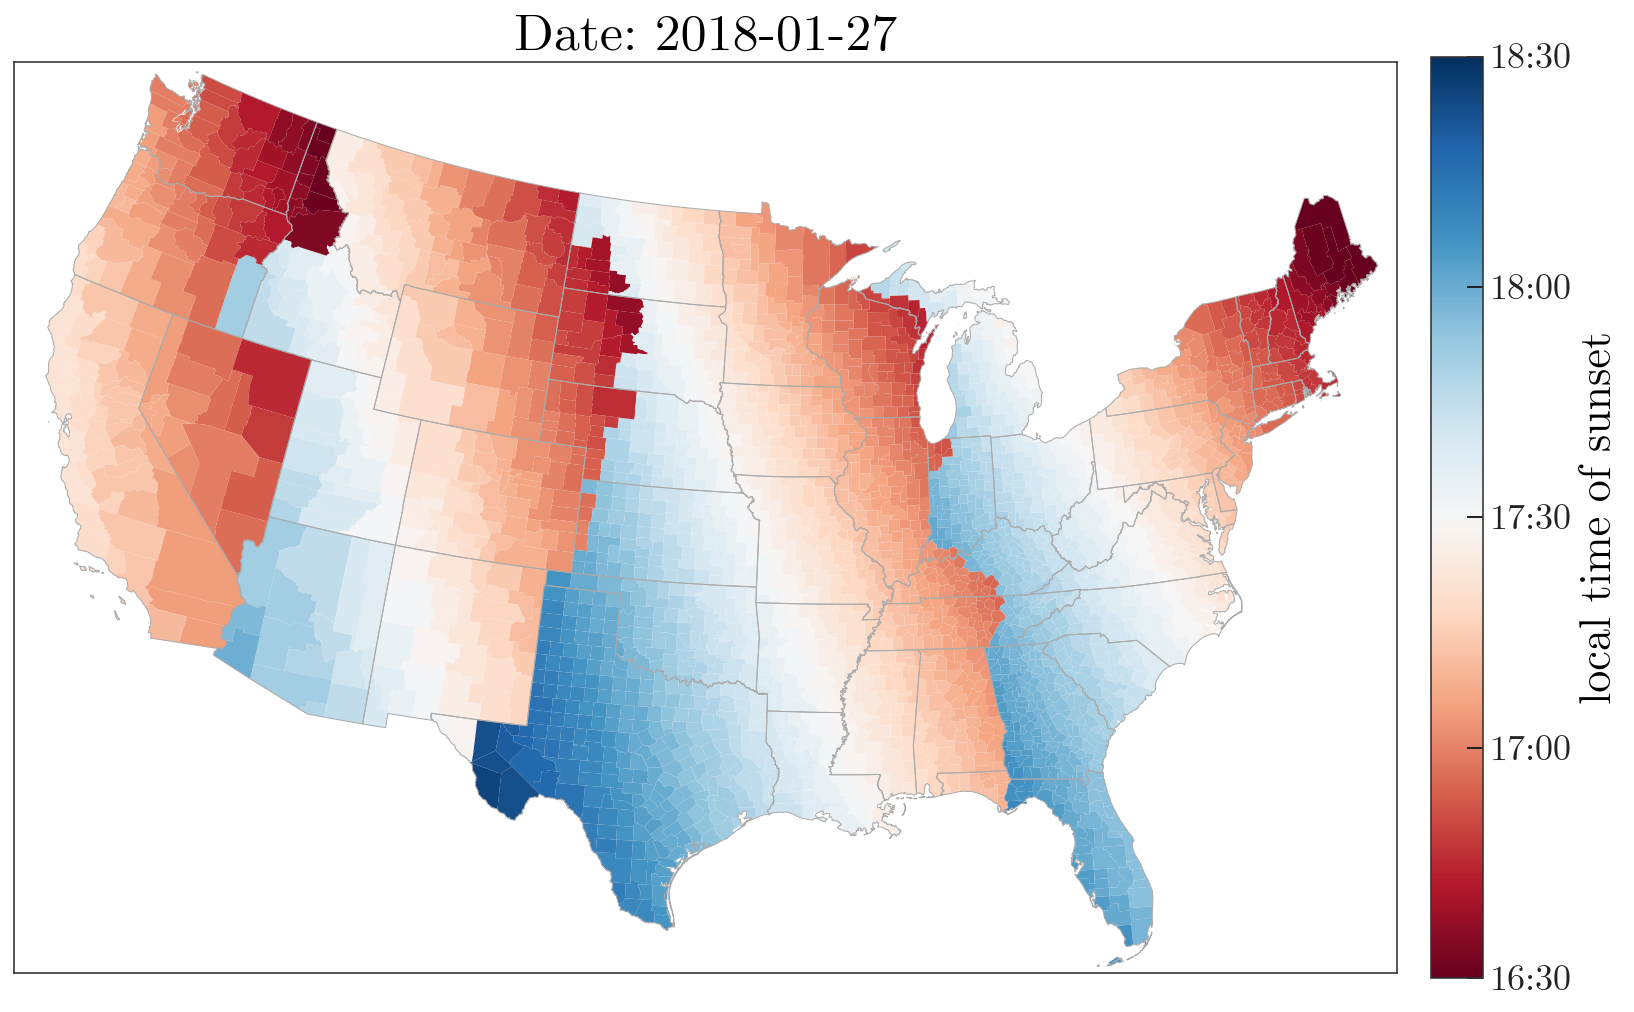

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.set_title('Date: {0}'.format(day.datetime.strftime('%Y-%m-%d')))

m = Basemap(resolution='l',  # crude, low, intermediate, high, full
            llcrnrlon=lon_lim[0], urcrnrlon=lon_lim[1],
            lon_0=center_lon,
            llcrnrlat=lat_lim[0], urcrnrlat=lat_lim[1],
            lat_0=center_lat,
            projection='tmerc', ax=ax)

# Read county boundaries
shp_info = m.readshapefile('../static/basemap-shapes/st99_d00',
                           'counties', drawbounds=True, color='#aaaaaa', linewidth=0.5)

shp_info = m.readshapefile('../static/basemap-shapes/cb_2015_us_county_500k',
                           'counties', drawbounds=False)

for i, info in enumerate(m.counties_info):
    match_idx = np.where(county['GEOID'][good_i] == int(info['GEOID']))[0]
    if match_idx in good_i:
        poly = Polygon(m.counties[i], 
                       facecolor=cmap(norm(sunset_hours[match_idx][0])))
        ax.add_patch(poly)
        
ax1 = fig.add_axes([0.92, 0.1, 0.03, 0.8]) # l, b, w, h
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm)
cb1.set_label('local time of sunset')

cb_ticks = np.arange(med_hour-1, med_hour+1+0.1, 0.5)
cb_labels = [datetime.time(int(x), int(60*(x - np.floor(x)))).strftime('%H:%M') 
             for x in cb_ticks]
cb1.set_ticks(cb_ticks)
cb1.set_ticklabels(cb_labels)

fig.subplots_adjust(0.1, 0.05, 0.9, 0.95) # l, b, r, t

Northwestern Washington and central New Jersey are both light red! From this map, it's clear that location within a timezone is a much stronger indicator of sunset time compared to the latitude dependence of the sunset.

Let's now turn the above into a single function call that produces the county map given a date:

In [34]:
def plot_sunset_map(day, cmap='RdBu'):
    """Plot a map of the continental US and color each county by the local
    time of sunset on the specified day.
    
    Parameters
    ----------
    day : `astropy.time.Time`
        The day to compute sunset on.
    """
    good_i, sunsets = sunset_time(county_locs, day, n_time=512)
    
    sunset_hours = np.array([s.hour + s.minute/60 + s.second/3600 
                             for s in sunsets])
    
    # Set the lower left and upper right limits of the bounding box of 
    # the US county map plot:
    lon_lim = (-119, -63)
    lat_lim = (22.0, 50.5)

    # calculate the centerpoint, needed for the projection:
    center_lon = 0.5 * np.sum(lon_lim)
    center_lat = 0.5 * np.sum(lat_lim)
    
    cmap = plt.get_cmap(cmap)
    med_hour = 0.5 * np.round(np.median(sunset_hours) / 0.5)
    norm = mpl.colors.Normalize(vmin=med_hour - 1, 
                                vmax=med_hour + 1)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.set_title('Date: {0}'.format(day.datetime.strftime('%Y-%m-%d')))

    m = Basemap(resolution='l',  # crude, low, intermediate, high, full
                llcrnrlon=lon_lim[0], urcrnrlon=lon_lim[1],
                lon_0=center_lon,
                llcrnrlat=lat_lim[0], urcrnrlat=lat_lim[1],
                lat_0=center_lat,
                projection='tmerc', ax=ax)

    # Read county boundaries
    shp_info = m.readshapefile('../static/basemap-shapes/st99_d00',
                               'counties', drawbounds=True, color='#aaaaaa', linewidth=0.5)

    shp_info = m.readshapefile('../static/basemap-shapes/cb_2015_us_county_500k',
                               'counties', drawbounds=False)

    for i, info in enumerate(m.counties_info):
        match_idx = np.where(county['GEOID'][good_i] == int(info['GEOID']))[0]
        if match_idx in good_i:
            poly = Polygon(m.counties[i], 
                           facecolor=cmap(norm(sunset_hours[match_idx][0])))
            ax.add_patch(poly)

    ax1 = fig.add_axes([0.92, 0.1, 0.03, 0.8]) # l, b, w, h
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm)
    cb1.set_label('local time of sunset')

    cb_ticks = np.arange(med_hour-1, med_hour+1+0.1, 0.5)
    cb_labels = [datetime.time(int(x), int(60*(x - np.floor(x)))).strftime('%H:%M') 
                 for x in cb_ticks]
    cb1.set_ticks(cb_ticks)
    cb1.set_ticklabels(cb_labels)

    fig.subplots_adjust(0.1, 0.05, 0.9, 0.95) # l, b, r, t
    
    return fig

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:49: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


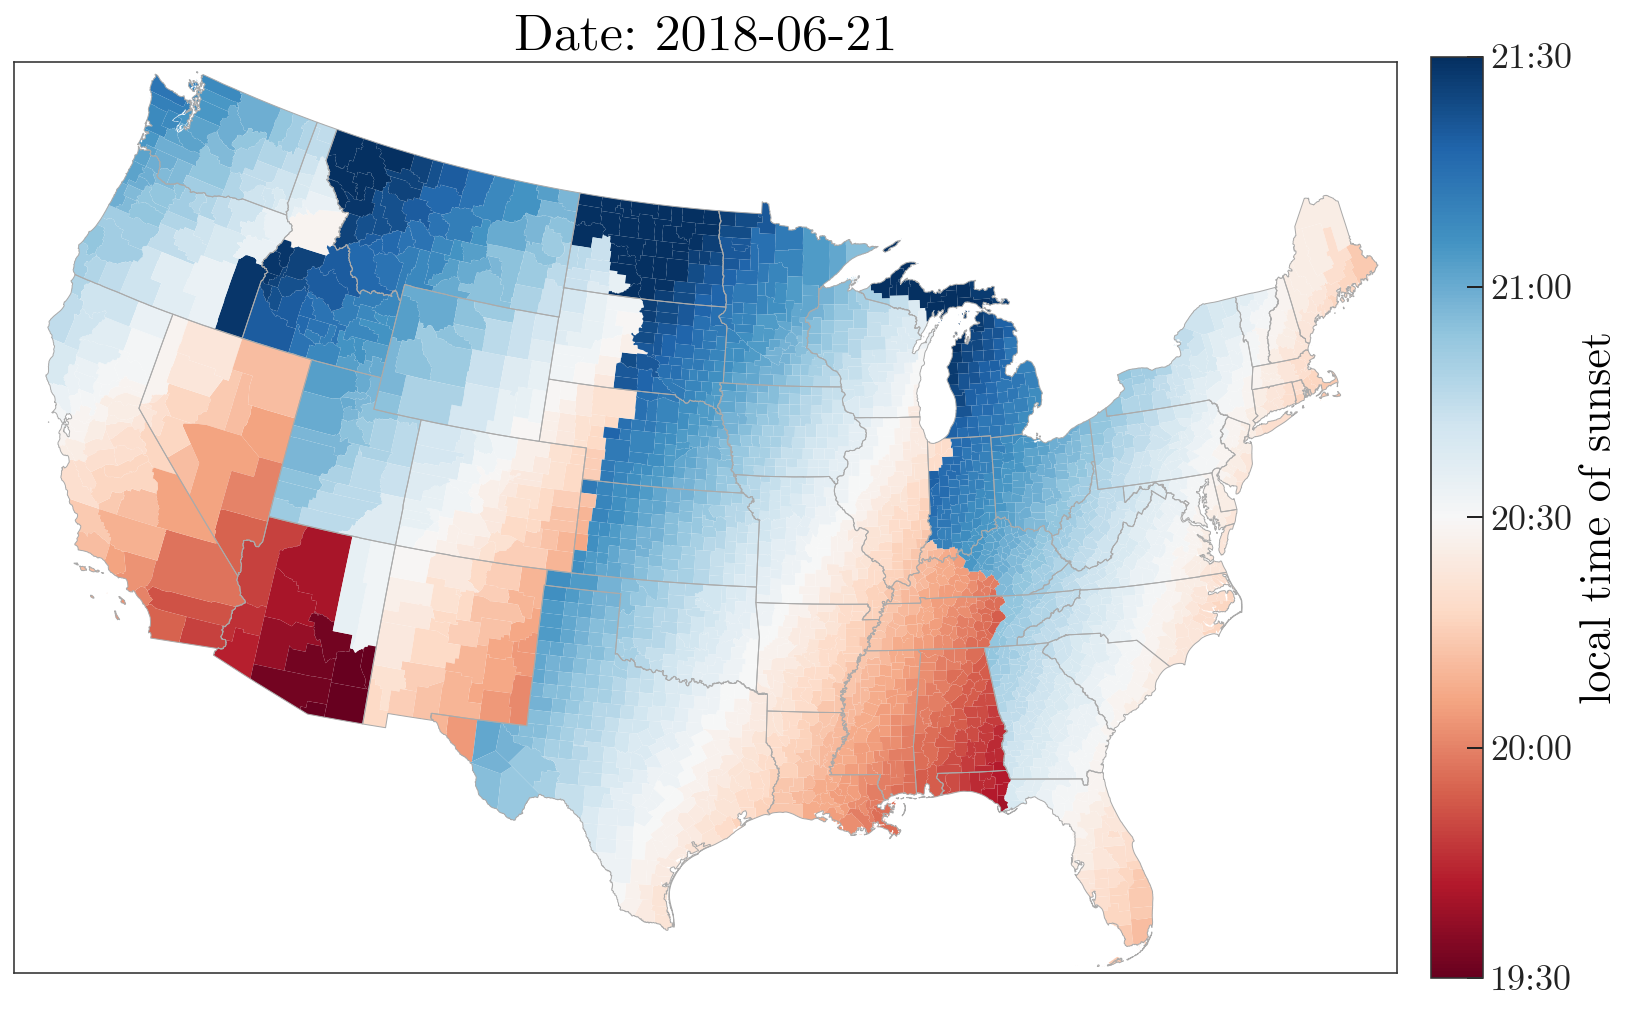

In [35]:
fig = plot_sunset_map(Time('2018-06-21'))

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:49: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


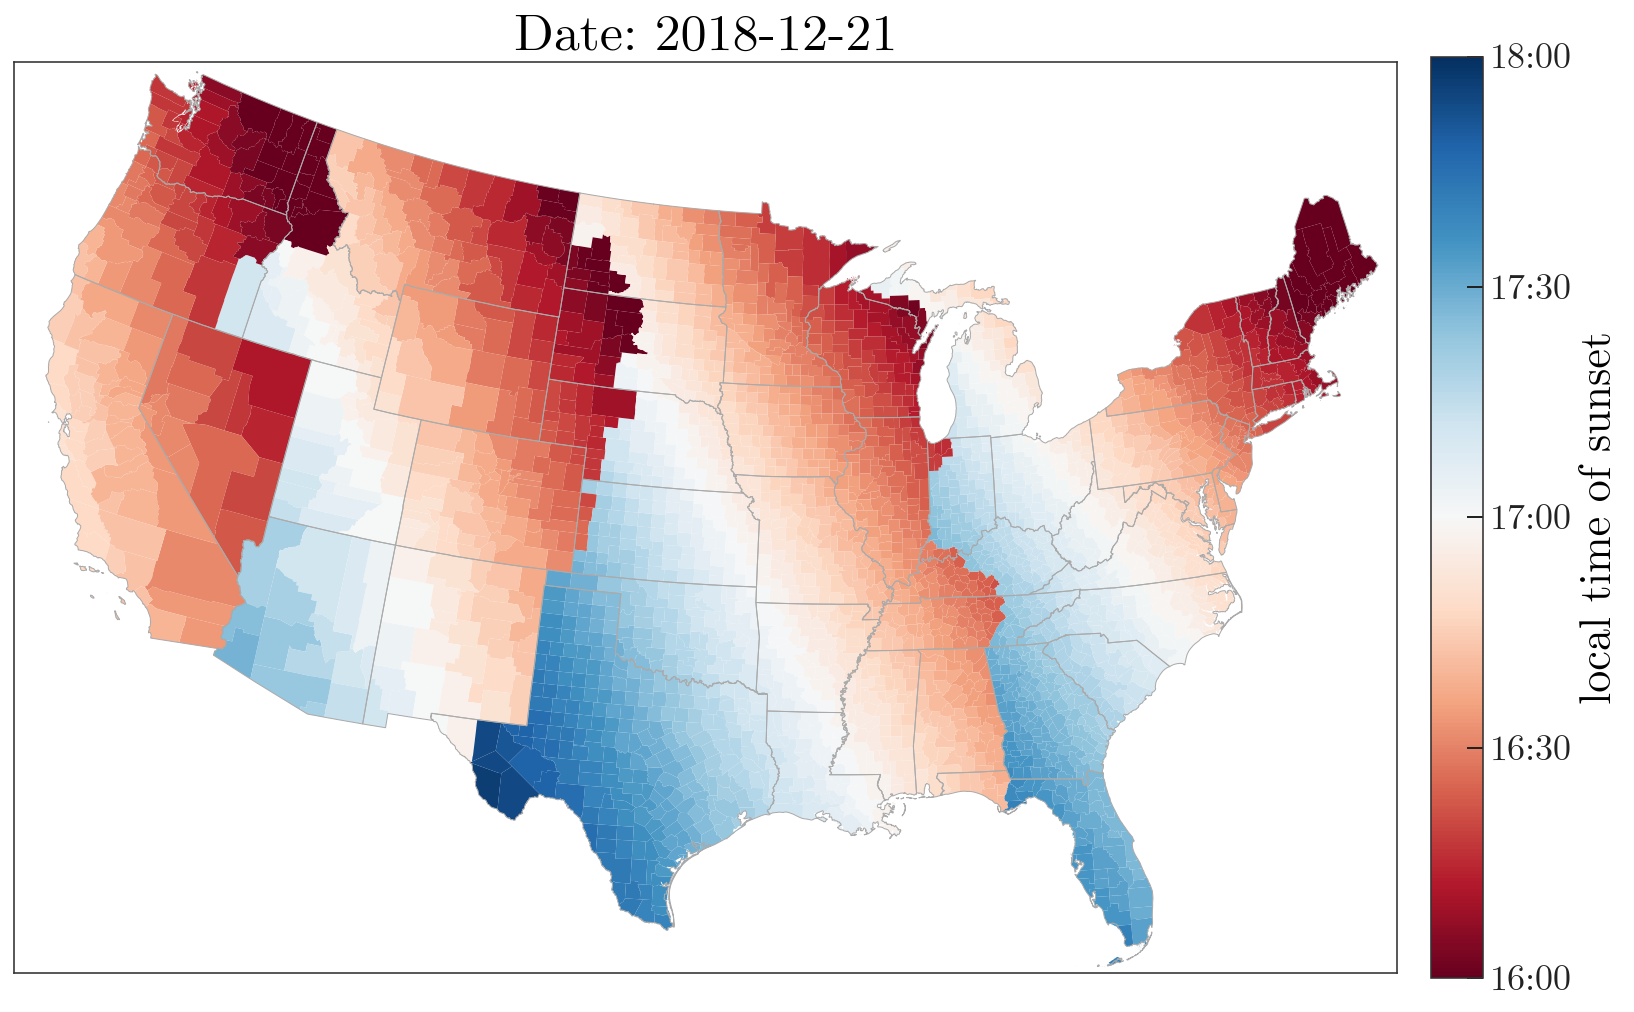

In [36]:
fig = plot_sunset_map(Time('2018-12-21'))